In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from abc import abstractmethod, ABC

In [2]:
class FunctionGenerator(ABC):

    def __init__(self, x_range, split, seed):

        self._x_range = x_range
        self._split = split
        self._seed = seed

        self.set_seed()

    def status(self):

        return {
            "x_range": self._x_range,
            "split": self._split,
            "seed": self._seed,
        }

    def set_seed(self):

        np.random.seed(self._seed)

        return

    def print_info(self, function, info):

        print("===== Function Generator Info =====")
        print(" > function: {}".format(function))

        for i in list(info.keys()):
            space = " "*(8-len(i))
            print(" > {}: {}{}".format(i, space, info[i]))

        print(" > x_range:  {}".format(self._x_range))
        print(" > split:    {}".format(self._split))
        print(" > seed:     {}".format(self._seed))
        print()

        return

    @abstractmethod
    def generate(self):
        pass

In [3]:
class TrigonometricGenerator(FunctionGenerator):

    def __init__(self, x_range, split, seed):

        super(TrigonometricGenerator, self).__init__(x_range, split, seed)

    def generate(self, num_data, num_func, num_sampling, limit_amp=[-5,5], limit_freq=[1,5]):
            
        x = np.linspace(self._x_range[0], self._x_range[1], self._split)

        amplitude = np.random.uniform(limit_amp[0], limit_amp[1], (num_data, num_func))
        frequency = np.random.uniform(limit_freq[0], limit_freq[1], (num_data, num_func))
        phase = np.random.uniform(0, 2*np.pi, (num_data, num_func))

        y = np.random.uniform(self._x_range[0], self._x_range[1], (num_data, num_sampling))

        u = np.zeros((num_data, self._split))
        u_derivative = np.zeros((num_data, self._split))
        u_integral = np.zeros((num_data, self._split))

        Gu_yd = np.zeros((num_data, num_sampling))
        Gu_yi = np.zeros((num_data, num_sampling))

        # calculate u
        for i in range(num_data):
            for j in range(num_func):
                u[i] += amplitude[i][j] * np.sin(frequency[i][j] * x + phase[i][j])

        # calculate G(u)(y)
        for i in range(num_data):
            for j in range(num_func):
                u_derivative[i] += amplitude[i][j] * frequency[i][j] * np.cos(frequency[i][j] * x + phase[i][j])
                u_integral[i] += -amplitude[i][j] / frequency[i][j] * np.cos(frequency[i][j] * x + phase[i][j])

                Gu_yd[i] += amplitude[i][j] * frequency[i][j] * np.cos(frequency[i][j] * y[i] + phase[i][j])
                Gu_yi[i] += -amplitude[i][j] / frequency[i][j] * np.cos(frequency[i][j] * y[i] + phase[i][j])

        self.print_info("trigonometric", {"num_data": num_func, "lim_coef": limit_amp, "lim_freq": limit_freq})

        data = {
            "u": u,
            "y": y,
            "Gu_yd": Gu_yd,
            "Gu_yi": Gu_yi
        }

        metadata = {
            "x": x,
            "amp": amplitude,
            "freq": frequency,
            "phase": phase,
            "u": u,
            "u_derivative": u_derivative,
            "u_integral": u_integral
        }

        return data, metadata

In [4]:
class PolynomialGenerator(FunctionGenerator):

    def __init__(self, x_range, split, seed):

        super(PolynomialGenerator, self).__init__(x_range, split, seed)

    def generate(self, num_data, degree, num_sampling, limit_coef=[-5,5], bias=None):

        x = np.linspace(self._x_range[0], self._x_range[1], self._split)

        coef = np.random.uniform(limit_coef[0], limit_coef[1], (num_data, degree+1))
        coef = coef * np.array([1] + [1/x for x in range(1,degree+1)])
        if bias is not None:
            coef[:,0] = np.random.uniform(bias[0], bias[1], num_data)

        y = np.random.uniform(self._x_range[0], self._x_range[1], (num_data, num_sampling))

        u = np.zeros((num_data, self._split))
        u_derivative = np.zeros((num_data, self._split))
        u_integral = np.zeros((num_data, self._split))

        Gu_yd = np.zeros((num_data, num_sampling))
        Gu_yi = np.zeros((num_data, num_sampling))

        # calculate u
        for i in range(num_data):

            if bias is not None:
                u[i] += coef[i][0]

            for j in range(1, degree+1):
                u[i] += coef[i][j] * x**j


        # calculate G(u)(y)
        for i in range(num_data):

            if bias is not None:

                u_derivative[i] += 0
                u_integral[i] += coef[i][0] * x

                Gu_yd[i] += 0
                Gu_yi[i] += coef[i][0] * y[i]

            for j in range(1,degree+1):
                u_derivative[i] += coef[i][j] * j * x**(j-1)
                u_integral[i] += coef[i][j] / (j+1) * x**(j+1)

                Gu_yd[i] += coef[i][j] * j * y[i]**(j-1)
                Gu_yi[i] += coef[i][j] / (j+1) * y[i]**(j+1)

        self.print_info("polynomial", {"num_data": degree, "degree": degree, "lim_coef": limit_coef, "bias": bias})

        data = {
            "u": u,
            "y": y,
            "Gu_yd": Gu_yd,
            "Gu_yi": Gu_yi
        }

        metadata = {
            "x": x,
            "coef": coef,
            "u": u,
            "u_derivative": u_derivative,
            "u_integral": u_integral
        }

        return data, metadata

In [5]:
class SimpleNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, layers, activation=nn.ReLU, output_activation=None):
        
        super(SimpleNetwork, self).__init__()

        self.activation = activation
        self.output_activation = output_activation

        self.layers = nn.ModuleList()
        layer_info = [input_size] + layers*[hidden_size] + [output_size]

        for i in range(len(layer_info)-1):

            self.layers.append(nn.Linear(layer_info[i], layer_info[i+1]))

        return
        

    def forward(self, x):
        
        for i in range(len(self.layers)):

            x = self.layers[i](x)

            if i==len(self.layers)-1:
                if self.output_activation is not None:
                    x = self.output_activation(x)
                else:
                    x = x
            else:
                x = self.activation(x)

        return x

In [6]:
class DeepONet(nn.Module):

    def __init__(self, input_size, hidden_size_b, hidden_size_t, output_size, layers, activation=nn.ReLU, output_activation=None):
        
        super(DeepONet, self).__init__()

        self.activation = activation
        self.output_activation = output_activation

        self.branch_net = SimpleNetwork(input_size, hidden_size_b, output_size, layers, activation=activation)
        self.trunk_net = SimpleNetwork(1, hidden_size_t, output_size, layers, activation=activation, output_activation=output_activation)

        return

    def forward(self, u, y):

        branch_feature = self.branch_net(u)
        trunk_feature = self.trunk_net(y)

        #global_feature = branch_feature[:,:-1] * trunk_feature
        global_feature = branch_feature * trunk_feature

        #output = global_feature.sum(dim=1, keepdim=True) + branch_feature[:,-1:]
        output = global_feature.sum(dim=1, keepdim=True)

        return output

In [7]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [8]:
x_range = [-2*np.pi, 2*np.pi]
split = 500
seed = 2434

num_data_train = 100
num_data_test = 5
num_func = 3
num_sampling = 50
limit_amp = [0, 2]
limit_freq = [0.3, 2]
degree = 3
limit_coef = [-0.1, 0.1]
bias = [-3, 3]

t_generator = TrigonometricGenerator(x_range, split, seed)
p_generator = PolynomialGenerator(x_range, split, seed)

In [9]:
t_generator.status(), p_generator.status()

({'x_range': [-6.283185307179586, 6.283185307179586],
  'split': 500,
  'seed': 2434},
 {'x_range': [-6.283185307179586, 6.283185307179586],
  'split': 500,
  'seed': 2434})

In [10]:
trigonometric_train, trigonometric_train_m = t_generator.generate(num_data_train, num_func, num_sampling, limit_amp=limit_amp, limit_freq=limit_freq)
polynomial_train, polynomial_train_m = p_generator.generate(num_data_train, degree, num_sampling, limit_coef=limit_coef, bias=bias)

===== Function Generator Info =====
 > function: trigonometric
 > num_data: 3
 > lim_coef: [0, 2]
 > lim_freq: [0.3, 2]
 > x_range:  [-6.283185307179586, 6.283185307179586]
 > split:    500
 > seed:     2434

===== Function Generator Info =====
 > function: polynomial
 > num_data: 3
 > degree:   3
 > lim_coef: [-0.1, 0.1]
 > bias:     [-3, 3]
 > x_range:  [-6.283185307179586, 6.283185307179586]
 > split:    500
 > seed:     2434



In [11]:
trigonometric_train

{'u': array([[-2.41439765, -2.35453284, -2.2914633 , ...,  0.53394508,
          0.52997402,  0.52512051],
        [-0.95335618, -0.89460655, -0.83423393, ..., -0.43999053,
         -0.38597095, -0.33093876],
        [-1.68959112, -1.73280286, -1.77536412, ..., -1.24135198,
         -1.26726303, -1.29308132],
        ...,
        [-1.95097608, -1.91107036, -1.86889924, ..., -0.88387707,
         -0.91311053, -0.94173616],
        [-1.75810855, -1.76407834, -1.76643794, ...,  2.17647277,
          2.07796977,  1.97546336],
        [ 0.03171254,  0.00673843, -0.01810246, ...,  2.88674432,
          2.87856334,  2.86945126]]),
 'y': array([[ 4.64701143,  3.31394992, -2.86763279, ..., -1.44628599,
         -2.41838032, -3.06305138],
        [-3.744881  ,  1.13144906, -3.75529313, ...,  5.2769412 ,
          4.78280078, -0.89039751],
        [ 0.82042029, -4.95598358, -5.79663398, ..., -4.81794665,
         -3.40698849, -0.48478386],
        ...,
        [ 4.53706212, -2.15142379,  2.834327

In [12]:
polynomial_train

{'u': array([[ 5.3953354 ,  5.32256175,  5.25029842, ..., -5.03594407,
         -5.08032034, -5.1250945 ],
        [-1.27781683, -1.2748016 , -1.27176604, ..., -1.75383498,
         -1.76786633, -1.78198681],
        [ 3.10680211,  3.09953257,  3.0923293 , ...,  1.59176655,
          1.58064646,  1.56944431],
        ...,
        [-4.80510856, -4.77575498, -4.74661092, ..., -1.04097699,
         -1.02484997, -1.00856594],
        [ 0.41405844,  0.42167078,  0.42916013, ...,  3.77178731,
          3.80756777,  3.84358529],
        [-0.32228357, -0.33983156, -0.35728394, ..., -1.47647056,
         -1.47205872, -1.46765431]]),
 'y': array([[ 2.52102418, -4.51383   , -3.39819221, ..., -1.43968769,
         -1.98915409,  2.30733488],
        [-4.72415002,  2.16839833,  4.6302832 , ..., -0.53643044,
          4.73747341,  4.50370924],
        [-4.92472878, -0.05405385,  1.06065507, ..., -1.75018277,
          0.10789071,  1.24651353],
        ...,
        [ 5.82535338, -5.7619372 ,  0.881468

In [ ]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)

for i in range(3):
    
    x = np.linspace(x_range[0], x_range[1], len(trigonometric_train["u"][i]))
    y = trigonometric_train["u"][i]
    plt.plot(x, y, label="trigonometric data {}".format(i+1), alpha=0.7)
    
for i in range(3):
    
    x = np.linspace(x_range[0], x_range[1], len(polynomial_train["u"][i]))
    y = polynomial_train["u"][i]
    plt.plot(x, y, label="polynomial data {}".format(i+1), alpha=0.7)

ax.set_xlabel("x",fontsize=14)
ax.set_ylabel("u(x)",fontsize=14)
ax.legend(loc="best", fontsize=9)

In [14]:
u_t = np.repeat(trigonometric_train["u"], num_sampling, axis=0)
y_t = trigonometric_train["y"].reshape(-1, 1)
Gu_y_t = trigonometric_train["Gu_yd"].reshape(-1, 1)

u_p = np.repeat(polynomial_train["u"], num_sampling, axis=0)
y_p = polynomial_train["y"].reshape(-1, 1)
Gu_y_p = polynomial_train["Gu_yd"].reshape(-1, 1)

u_train = torch.tensor(np.concatenate([u_t, u_p], axis=0)).float().to(device)
y_train = torch.tensor(np.concatenate([y_t, y_p], axis=0)).float().to(device)
Gu_y_train = torch.tensor(np.concatenate([Gu_y_t, Gu_y_p], axis=0)).float().to(device)

In [15]:
deeponet = DeepONet(
    input_size = split, 
    hidden_size_b = 64, 
    hidden_size_t = 64, 
    output_size = 64, 
    layers = 3, 
    activation = nn.ReLU(), 
    output_activation = None
).to(device)

In [16]:
deeponet

DeepONet(
  (activation): ReLU()
  (branch_net): SimpleNetwork(
    (activation): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=500, out_features=64, bias=True)
      (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (trunk_net): SimpleNetwork(
    (activation): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
    )
  )
)

In [18]:
optimizer = torch.optim.Adam(deeponet.parameters(), lr=0.001)
criterion = nn.MSELoss()

max_epoch = 1000
losses = []

for epoch in range(max_epoch):
    
    optimizer.zero_grad()
    
    output = deeponet(u_train, y_train)
    loss = criterion(output, Gu_y_train)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{max_epoch}], Loss: {loss.item():.8f}")
        losses.append(loss.cpu().detach().numpy().item())

Epoch [0/1000], Loss: 0.03490684
Epoch [10/1000], Loss: 0.28461754
Epoch [20/1000], Loss: 0.24432136
Epoch [30/1000], Loss: 0.16570181
Epoch [40/1000], Loss: 0.12610221
Epoch [50/1000], Loss: 0.09407042
Epoch [60/1000], Loss: 0.07307531
Epoch [70/1000], Loss: 0.05924682
Epoch [80/1000], Loss: 0.05042269
Epoch [90/1000], Loss: 0.04427968
Epoch [100/1000], Loss: 0.04010031
Epoch [110/1000], Loss: 0.03691362
Epoch [120/1000], Loss: 0.03450307
Epoch [130/1000], Loss: 0.03250968
Epoch [140/1000], Loss: 0.03086714
Epoch [150/1000], Loss: 0.02953633
Epoch [160/1000], Loss: 0.02839693
Epoch [170/1000], Loss: 0.02739834
Epoch [180/1000], Loss: 0.02653914
Epoch [190/1000], Loss: 0.02575467
Epoch [200/1000], Loss: 0.02501598
Epoch [210/1000], Loss: 0.02431426
Epoch [220/1000], Loss: 0.02364209
Epoch [230/1000], Loss: 0.02297767
Epoch [240/1000], Loss: 0.02234018
Epoch [250/1000], Loss: 0.02172873
Epoch [260/1000], Loss: 0.02113569
Epoch [270/1000], Loss: 0.02055391
Epoch [280/1000], Loss: 0.01998

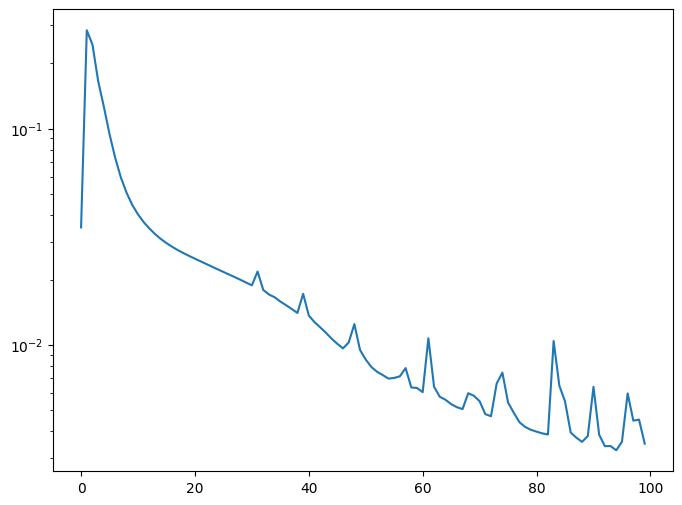

In [19]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)

ax.set_yscale("log")
ax.plot(losses)

In [20]:
num_data =10

trigonometric_test, trigonometric_test_m = t_generator.generate(num_data_test, num_func, num_sampling, limit_amp=limit_amp, limit_freq=limit_freq)
polynomial_test, polynomial_test_m = p_generator.generate(num_data_test, degree, num_sampling, limit_coef=limit_coef, bias=bias)

===== Function Generator Info =====
 > function: trigonometric
 > num_data: 3
 > lim_coef: [0, 2]
 > lim_freq: [0.3, 2]
 > x_range:  [-6.283185307179586, 6.283185307179586]
 > split:    500
 > seed:     2434

===== Function Generator Info =====
 > function: polynomial
 > num_data: 3
 > degree:   3
 > lim_coef: [-0.1, 0.1]
 > bias:     [-3, 3]
 > x_range:  [-6.283185307179586, 6.283185307179586]
 > split:    500
 > seed:     2434



In [21]:
u_t = np.repeat(trigonometric_test["u"], num_sampling, axis=0)
y_t = trigonometric_test["y"].reshape(-1, 1)
Gu_y_t = trigonometric_test["Gu_yd"].reshape(-1, 1)

u_p = np.repeat(polynomial_test["u"], num_sampling, axis=0)
y_p = polynomial_test["y"].reshape(-1, 1)
Gu_y_p = polynomial_test["Gu_yd"].reshape(-1, 1)

u_test = torch.tensor(np.concatenate([u_t, u_p], axis=0)).float().to(device)
y_test = torch.tensor(np.concatenate([y_t, y_p], axis=0)).float().to(device)
Gu_y_test = torch.tensor(np.concatenate([Gu_y_t, Gu_y_p], axis=0)).float().to(device)

MSE: 0.003155781188979745


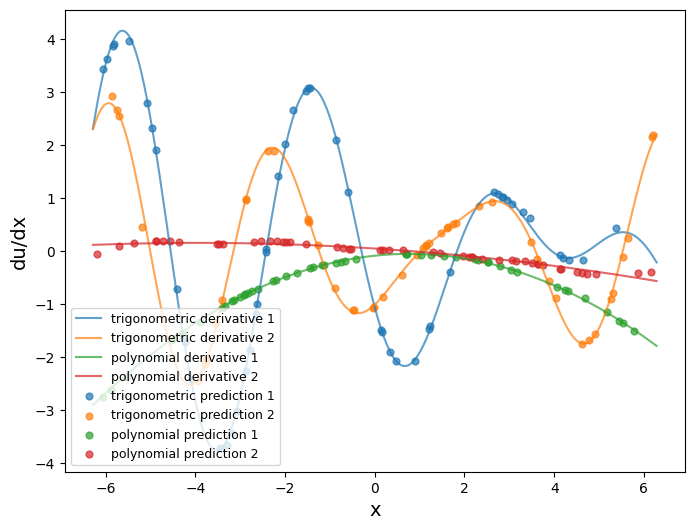

In [22]:
prediction = deeponet(u_train, y_train)

loss = criterion(prediction, Gu_y_train)
print(f"MSE: {loss}")

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)

for i in range(2):
    
    x = np.linspace(x_range[0], x_range[1], len(trigonometric_train_m["u_derivative"][i]))
    y = trigonometric_train_m["u_derivative"][i]
    plt.plot(x, y, label="trigonometric derivative {}".format(i+1), alpha=0.7)
    
for i in range(2):
    
    x = np.linspace(x_range[0], x_range[1], len(polynomial_train_m["u_derivative"][i]))
    y = polynomial_train_m["u_derivative"][i]
    plt.plot(x, y, label="polynomial derivative {}".format(i+1), alpha=0.7)
    
for i in range(2):
    
    x = y_train[i*num_sampling:(i+1)*num_sampling, :].cpu().detach().numpy().reshape(-1)
    y = prediction[i*num_sampling:(i+1)*num_sampling, :].cpu().detach().numpy().reshape(-1)
    plt.scatter(x, y, label="trigonometric prediction {}".format(i+1), alpha=0.7, s=24)
    
for i in range(2):
    
    x = y_train[num_data_train*num_sampling+i*num_sampling:num_data_train*num_sampling+(i+1)*num_sampling, :].cpu().detach().numpy().reshape(-1)
    y = prediction[num_data_train*num_sampling+i*num_sampling:num_data_train*num_sampling+(i+1)*num_sampling, :].cpu().detach().numpy().reshape(-1)
    plt.scatter(x, y, label="polynomial prediction {}".format(i+1), alpha=0.7, s=24)

ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("du/dx", fontsize=14)
ax.legend(loc="lower left", fontsize=9)

MSE: 0.04530101642012596


Text(0, 0.5, 'residual')

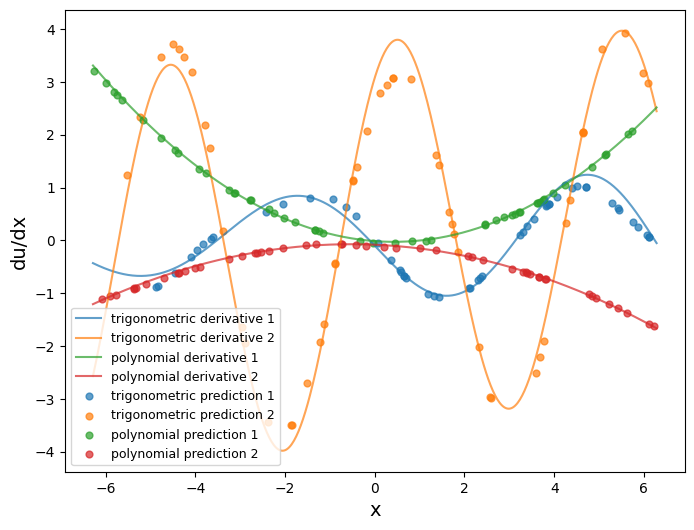

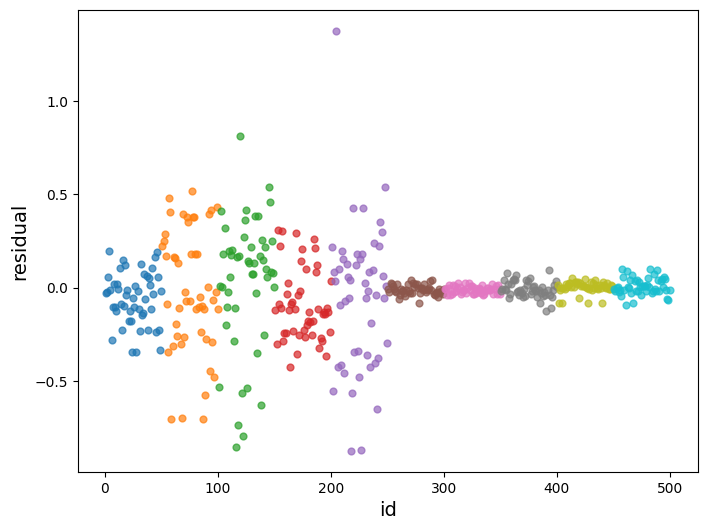

In [23]:
prediction = deeponet(u_test, y_test)

loss = criterion(prediction, Gu_y_test)
print(f"MSE: {loss}")

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)

for i in range(2):
    
    x = np.linspace(x_range[0], x_range[1], len(trigonometric_test_m["u_derivative"][i]))
    y = trigonometric_test_m["u_derivative"][i]
    plt.plot(x, y, label="trigonometric derivative {}".format(i+1), alpha=0.7)
    
for i in range(2):
    
    x = np.linspace(x_range[0], x_range[1], len(polynomial_test_m["u_derivative"][i]))
    y = polynomial_test_m["u_derivative"][i]
    plt.plot(x, y, label="polynomial derivative {}".format(i+1), alpha=0.7)
    
for i in range(2):
    
    x = y_test[i*num_sampling:(i+1)*num_sampling, :].cpu().detach().numpy().reshape(-1)
    y = prediction[i*num_sampling:(i+1)*num_sampling, :].cpu().detach().numpy().reshape(-1)
    plt.scatter(x, y, label="trigonometric prediction {}".format(i+1), alpha=0.7, s=24)
    
for i in range(2):
    
    x = y_test[num_data_test*num_sampling+i*num_sampling:num_data_test*num_sampling+(i+1)*num_sampling, :].cpu().detach().numpy().reshape(-1)
    y = prediction[num_data_test*num_sampling+i*num_sampling:num_data_test*num_sampling+(i+1)*num_sampling, :].cpu().detach().numpy().reshape(-1)
    plt.scatter(x, y, label="polynomial prediction {}".format(i+1), alpha=0.7, s=24)

ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("du/dx", fontsize=14)
ax.legend(loc="lower left", fontsize=9)

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)

for i in range(2*num_data_test):
    x = np.arange(1, len(prediction.cpu().detach().numpy().reshape(-1))+1)[i*num_sampling:(i+1)*num_sampling]
    y = (prediction-Gu_y_test).cpu().detach().numpy().reshape(-1)[i*num_sampling:(i+1)*num_sampling]
    ax.scatter(x, y, alpha=0.7, s=24)
    
ax.set_xlabel("id", fontsize=14)
ax.set_ylabel("residual", fontsize=14)